<a href="https://colab.research.google.com/github/gshreya5/colab/blob/main/market_basket_analysis_yuli_vasiliev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Market Basket Analysis through mlxtend’s Apriori algorithm
Source: Python for Data Science: A Hands-On Introduction
by Yuli Vasiliev 

Market basket analysis, a data mining technique that analyzes transactions and identifies items that are commonly purchased together.

## Load Dataset

In [3]:
transactions = [
 ['curd', 'sour cream'], ['curd', 'orange', 'sour cream'],
 ['bread', 'cheese', 'butter'], ['bread', 'butter'], ['bread', 'milk'],
 ['apple', 'orange', 'pear'], ['bread', 'milk', 'eggs'], ['tea', 'lemon'],
 ['curd', 'sour cream', 'apple'], ['eggs', 'wheat flour', 'milk'],
 ['pasta', 'cheese'], ['bread', 'cheese'], ['pasta', 'olive oil', 'cheese'],
 ['curd', 'jam'], ['bread', 'cheese', 'butter'],
 ['bread', 'sour cream', 'butter'], ['strawberry', 'sour cream'],
 ['curd', 'sour cream'], ['bread', 'coffee'], ['onion', 'garlic']
]

### turn transactions to one-hot encoded Boolean array ,
a structure where each column represents an item that can be purchased, each row represents a transaction, and each value is either True or False

In [1]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder


In [4]:
encoder = TransactionEncoder()
encoded_array = encoder.fit(transactions).transform(transactions)

In [24]:
df = pd.DataFrame(encoded_array,columns=encoder.columns_)

In [25]:
df.head()

,apple,bread,butter,cheese,coffee,curd,eggs,garlic,jam,lemon,milk,olive oil,onion,orange,pasta,pear,sour cream,strawberry,tea,wheat flour
0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False
2,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False


### Identifying Frequent Itemsets
with a high enough support metric

In [6]:
from mlxtend.frequent_patterns import apriori

In [26]:
freq_items = apriori(df,min_support=0.1,use_colnames=True)

In [27]:
freq_items['len'] = freq_items.itemsets.apply(lambda x: len(x) )

In [73]:
# remove single-item itemsets
freq_items[freq_items.len>1]  

,support,itemsets,len
10,0.20,"(bread, butter)",2
11,0.15,"(cheese, bread)",2
12,0.10,"(milk, bread)",2
13,0.10,"(cheese, butter)",2
14,0.10,"(cheese, pasta)",2
15,0.20,"(sour cream, curd)",2
16,0.10,"(eggs, milk)",2
17,0.10,"(cheese, bread, butter)",3


### Generating Association Rules

In [11]:
from mlxtend.frequent_patterns import association_rules

In [29]:
rules = association_rules(freq_items,metric='confidence',min_threshold=0.5)
rules=rules.iloc[:,:7]

fun = lambda x : str(x)[11:-2] 


rules.antecedents = list(map(fun, list(rules.antecedents.values)))
rules.consequents = list(map(fun, list(rules.consequents.values)))


### Visualizing Association Rules

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

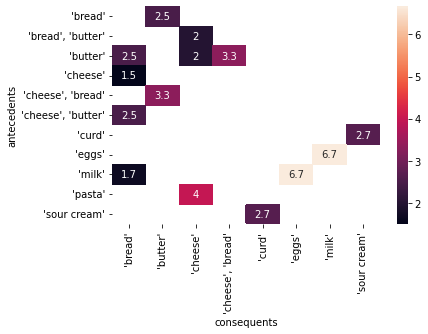

In [30]:
hm =rules.pivot(index=['antecedents'],columns=['consequents'],values=['lift'])
hm.columns = hm.columns.get_level_values(1)
sns.heatmap(hm,annot=True);

* strong association (eggs -> milk-> eggs) i.e customer that buys milk will buy eggs
* strong association (pasta -> cheese-> pasta) i.e a customer that buys pasta will buy cheese



In [65]:
df = rules[['antecedents','consequents']].copy()

fun = lambda x,y : str(sorted((str(x)+","+str(y)).replace("\'","").replace(" ","").split(",")))

df['union'] =  tuple(map(fun, df['antecedents'],df['consequents']))

df.drop_duplicates(subset=['union'],keep='first',inplace=True)
df

,antecedents,consequents,union
0,'bread','butter',"['bread', 'butter']"
2,'cheese','bread',"['bread', 'cheese']"
3,'milk','bread',"['bread', 'milk']"
4,'butter','cheese',"['butter', 'cheese']"
5,'pasta','cheese',"['cheese', 'pasta']"
6,'sour cream','curd',"['curd', 'sourcream']"
8,'eggs','milk',"['eggs', 'milk']"
10,"'cheese', 'bread'",'butter',"['bread', 'butter', 'cheese']"


Now based on these baskets, recommendations can be made, discounts can be planned  

In [75]:
df.union

0               ['bread', 'butter']
2               ['bread', 'cheese']
3                 ['bread', 'milk']
4              ['butter', 'cheese']
5               ['cheese', 'pasta']
6             ['curd', 'sourcream']
8                  ['eggs', 'milk']
10    ['bread', 'butter', 'cheese']
Name: union, dtype: object

In [72]:
pd.DataFrame([x for y in df.union for x in y.replace('[','').replace(']','').replace(' ','').split(",")],columns=["items"])["items"].value_counts()

'bread'        4
'cheese'       4
'butter'       3
'milk'         2
'pasta'        1
'curd'         1
'sourcream'    1
'eggs'         1
Name: items, dtype: int64

In [81]:
disc = set()
for x in df.union:
  basket = x.replace('[','').replace(']','').replace(' ','').split(",")

  if any(basket) not in disc:
    disc.add(basket[0])

print(disc)

  

{"'butter'", "'eggs'", "'cheese'", "'bread'", "'curd'"}


Only 5 items need to be discounted among 8  for every basket to have a discount

This can be improved by introducing filters in above function

# Let's mine a real transaction data

## Load data 

In [82]:
df_retail = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx', index_col=0, engine='openpyxl')

In [83]:
df = df_retail.copy()
df.drop_duplicates(inplace=True)
df.dropna(subset=['Description'],inplace=True)

Check for empty values

In [84]:
df.isna().sum()

StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133044
Country             0
dtype: int64

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 534608 entries, 536365 to 581587
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   StockCode    534608 non-null  object        
 1   Description  534608 non-null  object        
 2   Quantity     534608 non-null  int64         
 3   InvoiceDate  534608 non-null  datetime64[ns]
 4   UnitPrice    534608 non-null  float64       
 5   CustomerID   401564 non-null  float64       
 6   Country      534608 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 48.8+ MB


In [85]:
df.Description.astype({'Description':'str'})

InvoiceNo
536365     WHITE HANGING HEART T-LIGHT HOLDER
536365                    WHITE METAL LANTERN
536365         CREAM CUPID HEARTS COAT HANGER
536365    KNITTED UNION FLAG HOT WATER BOTTLE
536365         RED WOOLLY HOTTIE WHITE HEART.
                         ...                 
581587            PACK OF 20 SPACEBOY NAPKINS
581587           CHILDREN'S APRON DOLLY GIRL 
581587          CHILDRENS CUTLERY DOLLY GIRL 
581587        CHILDRENS CUTLERY CIRCUS PARADE
581587          BAKING SET 9 PIECE RETROSPOT 
Name: Description, Length: 534608, dtype: object

In [87]:
df.head(5)

,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
InvoiceNo,,,,,,,
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Get a transaction dataset

In [88]:
trans = df.groupby('InvoiceNo')['Description'].apply(list).to_list()

In [89]:
trans

[['WHITE HANGING HEART T-LIGHT HOLDER',
  'WHITE METAL LANTERN',
  'CREAM CUPID HEARTS COAT HANGER',
  'KNITTED UNION FLAG HOT WATER BOTTLE',
  'RED WOOLLY HOTTIE WHITE HEART.',
  'SET 7 BABUSHKA NESTING BOXES',
  'GLASS STAR FROSTED T-LIGHT HOLDER'],
 ['HAND WARMER UNION JACK', 'HAND WARMER RED POLKA DOT'],
 ['ASSORTED COLOUR BIRD ORNAMENT',
  "POPPY'S PLAYHOUSE BEDROOM ",
  "POPPY'S PLAYHOUSE KITCHEN",
  'FELTCRAFT PRINCESS CHARLOTTE DOLL',
  'IVORY KNITTED MUG COSY ',
  'BOX OF 6 ASSORTED COLOUR TEASPOONS',
  'BOX OF VINTAGE JIGSAW BLOCKS ',
  'BOX OF VINTAGE ALPHABET BLOCKS',
  'HOME BUILDING BLOCK WORD',
  'LOVE BUILDING BLOCK WORD',
  'RECIPE BOX WITH METAL HEART',
  'DOORMAT NEW ENGLAND'],
 ['JAM MAKING SET WITH JARS',
  'RED COAT RACK PARIS FASHION',
  'YELLOW COAT RACK PARIS FASHION',
  'BLUE COAT RACK PARIS FASHION'],
 ['BATH BUILDING BLOCK WORD'],
 ['ALARM CLOCK BAKELIKE PINK',
  'ALARM CLOCK BAKELIKE RED ',
  'ALARM CLOCK BAKELIKE GREEN',
  'PANDA AND BUNNIES STICKER SHEET'

one of the data point is numeric and throwing error so typecasting it to string type

In [90]:
trans[trans.index([20713])] = ['20713']

One hot encoder

In [91]:
from mlxtend.preprocessing import TransactionEncoder

In [92]:
encoder = TransactionEncoder()
encoded_array = encoder.fit(trans).transform(trans)

In [93]:
df = pd.DataFrame(encoded_array,columns=encoder.columns_)

In [94]:
df.head()

,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,wrongly coded 20713,wrongly coded 23343,wrongly coded-23343,wrongly marked,wrongly marked 23343,wrongly marked carton 22804,wrongly marked. 23343 in box,wrongly sold (22719) barcode,wrongly sold as sets,wrongly sold sets
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Apriori Model

In [95]:
from mlxtend.frequent_patterns import apriori

In [96]:
res = apriori(df,min_support=0.025,use_colnames=True)

In [97]:
res

,support,itemsets
0,0.039275,(6 RIBBONS RUSTIC CHARM)
1,0.025447,(60 CAKE CASES VINTAGE CHRISTMAS)
2,0.034202,(60 TEATIME FAIRY CAKE CASES)
3,0.025324,(72 SWEETHEART FAIRY CAKE CASES)
4,0.040952,(ALARM CLOCK BAKELIKE GREEN)
...,...,...
131,0.027329,"(JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO BAG ..."
132,0.029334,"(JUMBO STORAGE BAG SUKI, JUMBO BAG RED RETROSPOT)"
133,0.026511,"(LUNCH BAG BLACK SKULL., LUNCH BAG RED RETROS..."
134,0.025079,"(LUNCH BAG PINK POLKADOT, LUNCH BAG RED RETROS..."


Generating association rules

In [98]:
from mlxtend.frequent_patterns import association_rules

In [99]:
df = association_rules(res,min_threshold=0.3).pivot(index=['antecedents'],columns=['consequents'],values=['lift'])

In [100]:
item_set = association_rules(res,min_threshold=0.3).sort_values(['lift'],ascending=False)
item_set

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.032688,0.043203,0.026347,0.806008,18.656479,0.024935,4.932137
3,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.043203,0.032688,0.026347,0.609848,18.656479,0.024935,2.479323
17,(ROSES REGENCY TEACUP AND SAUCER ),(PINK REGENCY TEACUP AND SAUCER),0.045780,0.032688,0.025079,0.547811,16.758615,0.023582,2.139174
16,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.032688,0.045780,0.025079,0.767209,16.758615,0.023582,4.099042
4,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.043203,0.045780,0.032034,0.741477,16.196541,0.030056,3.691049
5,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.045780,0.043203,0.032034,0.699732,16.196541,0.030056,3.186477
1,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.044225,0.040952,0.026429,0.597595,14.592418,0.024618,2.383288
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.040952,0.044225,0.026429,0.645355,14.592418,0.024618,2.695015
14,(LUNCH BAG PINK POLKADOT),(LUNCH BAG RED RETROSPOT),0.045412,0.065663,0.025079,0.552252,8.410406,0.022097,2.086749
15,(LUNCH BAG RED RETROSPOT),(LUNCH BAG PINK POLKADOT),0.065663,0.045412,0.025079,0.381931,8.410406,0.022097,1.544470


Visualize the association

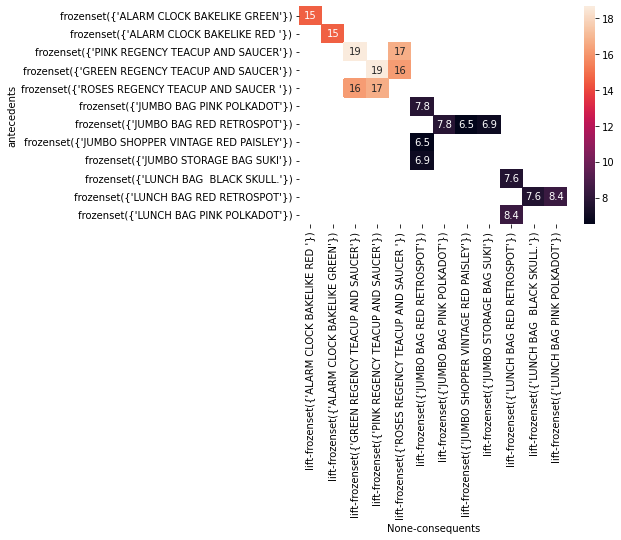

In [101]:
sns.heatmap(df,annot=True);

In [102]:
item_sets = item_set[['antecedents','consequents','lift']].copy()

In [104]:
from functools import reduce

In [105]:
item_sets['union'] = item_sets[['antecedents','consequents']].apply(lambda x: 
                                                                    reduce(frozenset.union, x), axis=1)

In [106]:
item_sets.drop_duplicates(subset=['union'], keep='first', inplace=True)

Following are the baskets according to apriori algorithm

In [107]:
item_sets

,antecedents,consequents,lift,union
2,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),18.656479,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY..."
17,(ROSES REGENCY TEACUP AND SAUCER ),(PINK REGENCY TEACUP AND SAUCER),16.758615,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY..."
4,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),16.196541,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC..."
1,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),14.592418,"(ALARM CLOCK BAKELIKE GREEN, ALARM CLOCK BAKEL..."
14,(LUNCH BAG PINK POLKADOT),(LUNCH BAG RED RETROSPOT),8.410406,"(LUNCH BAG PINK POLKADOT, LUNCH BAG RED RETROS..."
7,(JUMBO BAG RED RETROSPOT),(JUMBO BAG PINK POLKADOT),7.761466,"(JUMBO BAG PINK POLKADOT, JUMBO BAG RED RETROS..."
13,(LUNCH BAG RED RETROSPOT),(LUNCH BAG BLACK SKULL.),7.626411,"(LUNCH BAG BLACK SKULL., LUNCH BAG RED RETROS..."
10,(JUMBO STORAGE BAG SUKI),(JUMBO BAG RED RETROSPOT),6.940349,"(JUMBO BAG RED RETROSPOT, JUMBO STORAGE BAG SUKI)"
8,(JUMBO SHOPPER VINTAGE RED PAISLEY),(JUMBO BAG RED RETROSPOT),6.526371,"(JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO BAG ..."
